In [1]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
%matplotlib inline

import tsfel

In [3]:
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-06-27'

panel_data_antm = data.DataReader('ANTM.JK','yahoo',start_date, end_date)
panel_data_asii = data.DataReader('ASII.JK','yahoo',start_date, end_date)
panel_data_icbp = data.DataReader('ICBP.JK','yahoo',start_date, end_date)
panel_data_jsmr = data.DataReader('JSMR.JK','yahoo',start_date, end_date)


In [4]:
#antm
panel_data_antm['average'] = panel_data_antm[['Open','Close','High','Low']].mean(axis=1).round(2)
panel_data_antm['daily_return'] = panel_data_antm['Open'] - panel_data_antm['Close']
panel_data_antm['Volume'] = (panel_data_antm['Volume'].astype(float)/1000000)
#asii
panel_data_asii['average'] = panel_data_asii[['Open','Close','High','Low']].mean(axis=1).round(2)
panel_data_asii['daily_return'] = panel_data_asii['Open'] - panel_data_asii['Close']
panel_data_asii['Volume'] = (panel_data_asii['Volume'].astype(float)/1000000)
#icbp
panel_data_icbp['average'] = panel_data_icbp[['Open','Close','High','Low']].mean(axis=1).round(2)
panel_data_icbp['daily_return'] = panel_data_icbp['Open'] - panel_data_icbp['Close']
panel_data_icbp['Volume'] = (panel_data_icbp['Volume'].astype(float)/1000000)
#jsmr
panel_data_jsmr['average'] = panel_data_jsmr[['Open','Close','High','Low']].mean(axis=1).round(2)
panel_data_jsmr['daily_return'] = panel_data_jsmr['Open'] - panel_data_jsmr['Close']
panel_data_jsmr['Volume'] = (panel_data_jsmr['Volume'].astype(float)/1000000)

In [5]:
# Get Numerical features from dataset
numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
numerical_features = list(panel_data_antm.select_dtypes(include=numerics).columns)

In [7]:
data_saham = panel_data_antm[numerical_features]

In [8]:
data_saham.shape

(3091, 8)

In [9]:
data_saham.head()

,High,Low,Open,Close,Volume,Adj Close,average,daily_return
Date,,,,,,,,
2010-01-04,1931.946777,1847.949097,1931.946777,1931.946777,39.619544,1576.277222,1910.95,0.0
2010-01-05,1994.945068,1931.946777,1931.946777,1931.946777,62.041590,1576.277222,1947.70,0.0
2010-01-06,1994.945068,1910.947388,1931.946777,1931.946777,30.916328,1576.277222,1942.45,0.0
2010-01-07,1994.945068,1931.946777,1973.945557,1973.945557,30.624653,1610.544189,1968.70,0.0
2010-01-08,1994.945068,1952.946167,1973.945557,1973.945557,15.857579,1610.544189,1973.95,0.0


In [10]:
X = data_saham.drop('Adj Close', axis=1)
X.shape

(3091, 7)

In [11]:
y = data_saham['Adj Close']
y.shape

(3091,)

In [12]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2163, 7), (2163,), (928, 7), (928,))

In [13]:
# Calculate Univariate Statistical measure between each variable and target
univariate = f_regression(X_train.fillna(0), y_train)
univariate

(array([8.91684845e+04, 7.38122341e+04, 7.52905434e+04, 8.49442949e+04,
        2.50697539e+02, 8.32690960e+04, 3.64766299e+00]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.65608169e-53, 0.00000000e+00, 5.62802096e-02]))

In [14]:
# Capture P values in a series
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False, inplace=True)

<AxesSubplot:>

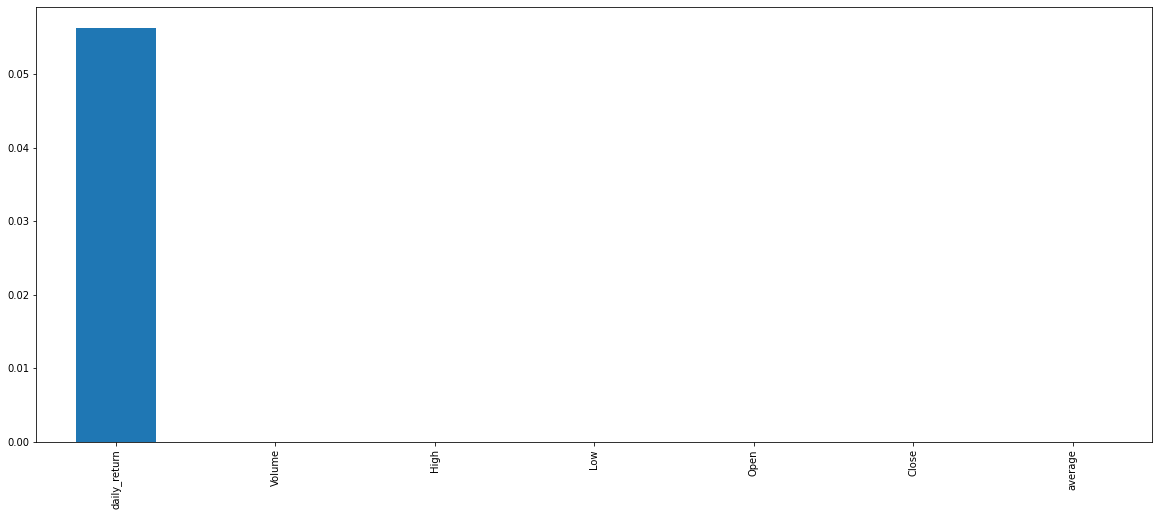

In [15]:
# Plot the P values
univariate.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [16]:
# Select K percentile Features
k_percentile_features = SelectPercentile(f_regression, percentile=10).fit(X_train.fillna(0), y_train)
X_train.columns[k_percentile_features.get_support()]

Index(['High'], dtype='object')

In [17]:
X_train = k_percentile_features.transform(X_train.fillna(0))
X_train.shape

(2163, 1)